# Import module and important variable

In [1]:
#!jupyter nbconvert --to script model_build.ipynb

import os
#import own module

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
import copy
import psutil
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
# import tensorflow_addons as tfa
import pickle
import random
import sys
import time
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from statistics import mean
from tensorflow.python.client import device_lib
from tensorflow.keras import backend as K
# from attention import Attention
# from keras_self_attention import SeqSelfAttention
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, r2_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report


from sklearn.model_selection import train_test_split, KFold
#from keras.utils import to_categorical
from scipy import stats
from datetime import datetime
from time import sleep
#from geopy import distance 



2023-05-09 20:53:14.140005: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
print(tf.__version__)

2.4.1


In [3]:
tf.config.experimental.list_physical_devices('GPU')
device_lib.list_local_devices()

2023-05-09 20:53:16.611614: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-09 20:53:16.613832: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-09 20:53:16.679180: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-09 20:53:16.680160: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:1c:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-09 20:53:16.681104: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:1d:00.0 name: Quadro RTX 600

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11575213136731063298,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 23264875008
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 2
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 3
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 4
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 5
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 6
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 7
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 12250815886497886168
 physical_device_desc: "device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capability: 7.5",
 name:

In [4]:
TASK_TYPE = ['DPT', 'MA', 'PVT', 'VWM']
RUN_TYPE = ['All_task','DPT', 'MA', 'PVT', 'VWM']
NORMALIZE_FEATURES = ['Pupil Diameter', 'Pupil X', 'Pupil Y']
#NORMALIZE_FEATURES = ['Pupil Diameter']
TIME_INTERVAL_EACH_SAMPLE = 4
NUMBER_OF_TIME_SAMPLE = 250 * TIME_INTERVAL_EACH_SAMPLE
NUMBER_OF_CHANNELS = 1
NUMBER_OF_INTERVAL_EACH_CHANNEL = NUMBER_OF_TIME_SAMPLE//NUMBER_OF_CHANNELS

In [5]:
CURRENT_TASK = RUN_TYPE[0]
MODEL_NAME = 'Create_plot'
RUN = 'run13_'+ MODEL_NAME+ '/'# + CURRENT_TASK+'/' + 'Trial' + str(0) +'/'


CURRENT_DIR = '/nfs/ada/jbrook1/common'
DATA_DIR = CURRENT_DIR + '/data/'
MASTER_OUTPUT_DIR = CURRENT_DIR + '/output/'
OUTPUT_DIR = MASTER_OUTPUT_DIR + RUN
print(DATA_DIR)
print(OUTPUT_DIR)

/nfs/ada/jbrook1/common/data/
/nfs/ada/jbrook1/common/output/run13_Create_plot/


In [6]:
CURRENT_TASK

'All_task'

# Preprocessing

## Load data

In [7]:
behavior_df = pd.read_pickle(DATA_DIR + 'behavior_data.pickle')
#behavior_df = pd.read_csv(DATA_DIR + 'behavior_data.csv')
behavior_df

,Task Type,SID,Trial,Stimulus Time,Reaction Time,isCorrectResponse
0,DPT,0,0,1.402413,605.970,1.0
1,DPT,0,0,4.852193,486.175,1.0
2,DPT,0,0,8.401990,443.381,1.0
3,DPT,0,0,11.735102,546.256,1.0
4,DPT,0,0,15.518205,487.143,1.0
...,...,...,...,...,...,...
112195,VWM,57,7,220.884844,322.137,1.0
112196,VWM,57,7,228.184393,379.615,1.0
112197,VWM,57,7,235.350625,352.227,1.0
112198,VWM,57,7,243.966769,353.536,1.0


In [8]:
eye_df = pd.read_pickle(DATA_DIR + 'eye_data.pickle')
#eye_df = pd.read_csv(DATA_DIR + 'eye_data.csv')
eye_df

,Task Type,SID,Trial,Time,Pupil Diameter,Pupil X,Pupil Y
0,DPT,0,0,0.004,5.884283,652.900024,223.100006
1,DPT,0,0,0.008,5.884123,652.799988,223.300003
2,DPT,0,0,0.012,5.883903,653.299988,223.800003
3,DPT,0,0,0.016,5.883621,653.799988,224.399994
4,DPT,0,0,0.020,5.883276,653.400024,224.699997
...,...,...,...,...,...,...,...
157740006,VWM,57,7,274.820,2.233881,554.400024,395.899994
157740007,VWM,57,7,274.824,2.233667,551.400024,399.000000
157740008,VWM,57,7,274.828,2.234875,551.700012,394.899994
157740009,VWM,57,7,274.832,2.237447,550.799988,403.799988


## Create plot

In [140]:
def Generate_plot(TYPE_OF_TASK, SUBJECT_LIST, NUMBER_OF_TRIAL, NUMBER_TO_GENERATE,behaviour_data, eye_data):
    behavior_grouped = behaviour_data.groupby(['Task Type', 'SID', 'Trial'])
    eye_grouped = eye_data.groupby(['Task Type', 'SID', 'Trial'])

    X = {}
    Y = {}
    for task_type in tqdm(TYPE_OF_TASK, desc='Task_type'):
        if task_type != CURRENT_TASK and CURRENT_TASK  != 'All_task':
            continue
        #for each task_type
        X_temp = []
        Y_temp = []
        for sid in tqdm(SUBJECT_LIST, desc='Subject ID'):
            print(sid)
            #for each subject id
            for i in range(NUMBER_OF_TRIAL):
                #for each trial
                
                #if the data is not availible, it will raise an error
                try:
                    behavior_temp = behavior_grouped.get_group((task_type,sid,i))
                except:
                    continue
                eye_temp = eye_grouped.get_group((task_type,sid,i))

                for j in behavior_temp['Stimulus Time']:
                    #for each stimulus time, j is the stimulus time
                    for k in range(NUMBER_TO_GENERATE):
                        # k is the number of sample to generate after the time j
                        # the first samples is a positive sample, all sample after the first will the the negative sample
                        
                        ###########################
                        #This code will generate X#
                        ###########################
                        begin = j + k*TIME_INTERVAL_EACH_SAMPLE-0.5
                        end = begin + TIME_INTERVAL_EACH_SAMPLE
                        eye_temp2 = eye_temp.query('Time >= @begin and Time <= @end')
                        if eye_temp2.shape[0] == 0:
                            #This is an empty case
                            continue

                        if eye_temp2.isna().sum().sum() != 0:
                            #This is an missing data case, drop the sample
                            continue

                        if eye_temp2.shape[0] == NUMBER_OF_TIME_SAMPLE + 1:
                            #this is an extra sample case, drop the last one
#                             print(eye_temp2.shape, ' sid:', sid, ' i:', i, ' j:', j)
                            eye_temp2 = eye_temp2.drop(eye_temp2.tail(1).index)
    
    
                        if eye_temp2.shape[0] != NUMBER_OF_TIME_SAMPLE:
                            #This is error case where the shape mismatch
                            print("Shape mismatch: ", eye_temp2.shape[0])
                            print(j)
                            continue
                        
                        #get the pupil diameter where the stimulus started 
                        eye_temp3 = eye_temp2.query('Time >= @j')
                        
                        X_temp.append(eye_temp2['Pupil Diameter']-eye_temp3['Pupil Diameter'].iloc[0])
#                         X.append(eye_temp2[['Pupil Diameter']])

                        ###########################
                        #This code will generate Y#
                        ###########################
                        Y_temp.append(eye_temp2['Time']-j)
                        
                        #end k loop
                    # end j loop
                #end i loop
            #end sid loop
            
        X[task_type] = np.array(X_temp)
        Y[task_type] = np.array(Y_temp)
        #end task_type loop


    return X, Y

In [141]:
subject = [i for i in range (58)]
Y, X = Generate_plot(TASK_TYPE, subject, 10, 1, behavior_df, eye_df)

Task_type:   0%|          | 0/4 [00:00<?, ?it/s]

Subject ID:   0%|          | 0/58 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


Subject ID:   0%|          | 0/58 [00:00<?, ?it/s]

0
1
2
3
4
5
Shape mismatch:  983
0.434364
6
7
8
9
10
11
12
13
Shape mismatch:  980
0.421793
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


Subject ID:   0%|          | 0/58 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


Subject ID:   0%|          | 0/58 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


In [144]:
for i in TASK_TYPE:
    print(X[i].shape)
print()
for i in TASK_TYPE:
    print(Y[i].shape)

(9600, 1000)
(2407, 1000)
(3822, 1000)
(9108, 1000)

(9600, 1000)
(2407, 1000)
(3822, 1000)
(9108, 1000)


In [146]:
X_ave = {}
Y_ave = {}
for i in TASK_TYPE:
    X_ave[i] = np.average(X[i],axis=0)
    Y_ave[i] = np.average(Y[i],axis=0)
    print(X_ave[i].shape)

(1000,)
(1000,)
(1000,)
(1000,)


In [158]:
temp_x = []
temp_y = []
for i in TASK_TYPE:
    temp_x.append(X_ave[i])
    temp_y.append(Y_ave[i])

    
temp_x = np.array(temp_x)
temp_y = np.array(temp_y)

X_ave['All_Tasks'] = np.average(temp_x,axis=0)
Y_ave['All_Tasks'] = np.average(temp_y,axis=0)

In [162]:
X_ave.keys()

dict_keys(['DPT', 'MA', 'PVT', 'VWM', 'All_Tasks'])

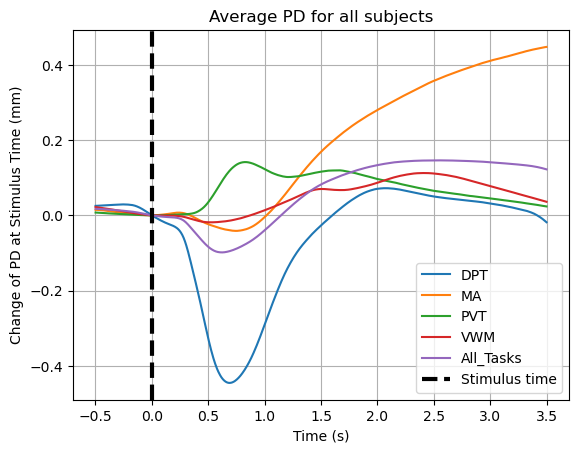

In [164]:
plt.clf()
for i in X_ave.keys():
    plt.plot(X_ave[i],Y_ave[i],label = i)
plt.axvline(x = 0, color = 'black', linestyle = '--', linewidth = 3,label = 'Stimulus time')
plt.xlabel('Time (s)')
plt.ylabel('Change of PD at Stimulus Time (mm)')
#plt.ylim(-0.5,0.5)
plt.title('Average PD for all subjects')
plt.grid()
plt.legend()


if(not(os.path.exists(OUTPUT_DIR))):
    os.makedirs(OUTPUT_DIR)
plt.savefig(OUTPUT_DIR +'Ave_'+ CURRENT_TASK +'_all_subjects.png')
plt.show()

## Create Plot 2

In [64]:
behaviour_task = behavior_df[behavior_df['Task Type'] == 'PVT'][behavior_df['SID'] == 3]
eye_task = eye_df[eye_df['Task Type'] == 'PVT'][eye_df['SID'] == 3]

/tmp/ipykernel_212172/2567409143.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  behaviour_task = behavior_df[behavior_df['Task Type'] == 'PVT'][behavior_df['SID'] == 3]
/tmp/ipykernel_212172/2567409143.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eye_task = eye_df[eye_df['Task Type'] == 'PVT'][eye_df['SID'] == 3]


In [65]:
eye_task

,Task Type,SID,Trial,Time,Pupil Diameter,Pupil X,Pupil Y
100607632,PVT,3,0,0.004,5.123237,548.599976,375.399994
100607633,PVT,3,0,0.008,5.124882,550.400024,377.000000
100607634,PVT,3,0,0.012,5.125620,548.099976,380.200012
100607635,PVT,3,0,0.016,5.125636,547.099976,382.299988
100607636,PVT,3,0,0.020,5.125458,547.700012,380.700012
...,...,...,...,...,...,...,...
100763400,PVT,3,0,623.076,3.535948,181.100006,379.299988
100763401,PVT,3,0,623.080,3.535948,226.399994,367.799988
100763402,PVT,3,0,623.084,3.535948,273.399994,351.700012
100763403,PVT,3,0,623.088,3.535948,314.299988,328.700012


In [66]:
behaviour_task

,Task Type,SID,Trial,Stimulus Time,Reaction Time,isCorrectResponse
54144,PVT,3,0,4.656809,447.530031,1.0
54145,PVT,3,0,8.189929,299.379110,1.0
54146,PVT,3,0,15.539491,332.659960,1.0
54147,PVT,3,0,26.938812,332.275152,1.0
54148,PVT,3,0,35.321642,316.307068,1.0
...,...,...,...,...,...,...
54219,PVT,3,0,566.639859,415.877819,1.0
54220,PVT,3,0,577.105885,381.999969,1.0
54221,PVT,3,0,582.538903,449.282885,1.0
54222,PVT,3,0,591.038398,399.017811,1.0


In [67]:
s_time = behaviour_task['Stimulus Time'].iloc[:5].to_list()
s_time

[4.656809, 8.189929, 15.539491, 26.938812, 35.321642]

In [68]:
r_time = behaviour_task['Reaction Time'].iloc[:5].to_list()
r_time = np.array(r_time)/1000 + s_time
r_time

array([ 5.10433903,  8.48930811, 15.87215096, 27.27108715, 35.63794907])

In [73]:
f_time = r_time + 1
f_time

array([ 6.10433903,  9.48930811, 16.87215096, 28.27108715, 36.63794907])

/tmp/ipykernel_212172/2163272699.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(eye_task['Time'][0:10000],eye_task['Pupil Diameter'][0:10000],label = "Pupil Diameter")


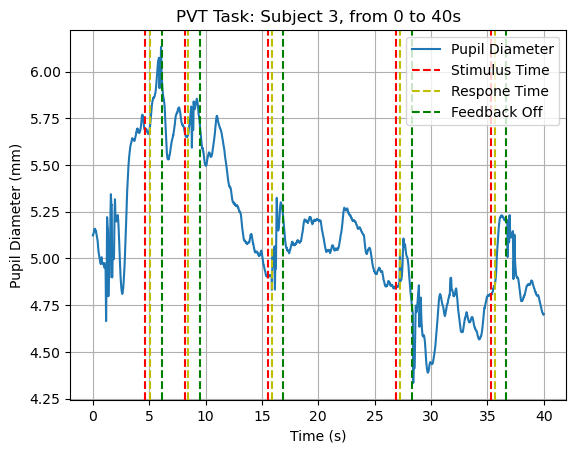

In [75]:
plt.clf()
plt.plot(eye_task['Time'][0:10000],eye_task['Pupil Diameter'][0:10000],label = "Pupil Diameter")

for i, value in enumerate(s_time):
    if i == 0:
        plt.axvline(x = value, color = 'red', linestyle = '--', label = 'Stimulus Time')
    else :
        plt.axvline(x = value, color = 'red', linestyle = '--')
        
for i, value in enumerate(r_time):
    if i == 0:
        plt.axvline(x = value, color = 'y', linestyle = '--', label = 'Respone Time')
    else :
        plt.axvline(x = value, color = 'y', linestyle = '--')
        
for i, value in enumerate(f_time):
    if i == 0:
        plt.axvline(x = value, color = 'g', linestyle = '--', label = 'Feedback Off')
    else :
        plt.axvline(x = value, color = 'g', linestyle = '--')
plt.xlabel('Time (s)')
plt.ylabel('Pupil Diameter (mm)')
#plt.ylim(-0.5,0.5)
plt.title('PVT Task: Subject 3, from 0 to 40s')
plt.grid()
plt.legend(loc='upper right')


if(not(os.path.exists(OUTPUT_DIR))):
    os.makedirs(OUTPUT_DIR)
plt.savefig(OUTPUT_DIR + 'PD_DPT_subject_3_first_40s.png')
plt.show()